In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
from keras.models import load_model
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import tensorflow as tf
from tensorflow.python.client import device_lib
import matplotlib.patches as mpatches



/home/sam/tensorflow/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(device_lib.list_local_devices())
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 4} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)
print("----------------------------")
print
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4146927307704987217
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11275639194
locality {
  bus_id: 1
}
incarnation: 13903450551523636060
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
----------------------------

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10868888755523043332
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 355336192
locality {
  bus_id: 1
}
incarnation: 8776988389981111760
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


# TODO:
* Record trials in an organized excel sheet, or write out each one to a .txt file 
* 


## Generate sine wave data points

In [3]:
#Define characteristics of the data to generate
num_cycles = 20
sample_rate = 0.1
points_per_cycle = int((2*np.pi) / sample_rate)

#Sample from a pure sine wave
data = [np.sin(i) for i in np.arange(start=0, stop=num_cycles*2*np.pi, step=sample_rate)]

print("Total data points: " + str(len(data)))


Total data points: 1257


## Data Formatting
* `series_to_examples`: Function to convert a 1D series into example data consisting of `X` and `Y` columns
* `prepare_data`: Function to prepare and split data into `train`/`test` sets

* NOTE: We can also add scaling in these functions, to squash values closer together


In [4]:
# Convert 1D series into example data of X and Y columns
def series_to_examples(series, n_prev=1, n_forecast=1, dropnan=True):
    """
    Transform time series data into supervised learning dataset.
    Arguments: 
        series: Sequence of observations as a list
        n_prev: Number of lag observations as input (X)
        n_forecast: Number of observations to predict (Y)
        dropnan: Boolean to drop rows with NaN values resulting from shift
    Returns:
        Pandas Dataframe
        
    Note: by this logic we should have N = (n_prev + n_forecast) columns
     and (series_len - N + 1) rows
    """
    
    #Robust check for whether or not series is univariate or multi-variate
    #If not a simple list (univariate), then the columns of shape will tell you how many variables
    num_dims = 1 if type(series) is list else series.shape[1]
    
    #convert the series to a dataframe format for shift
    df = pd.DataFrame(series)
    
    #Cols is a list of lists where each inner list is a whole column
    cols, names = list(), list()
    
    #Build each column of the input, first column will be fully shifted (i.e oldest example seen) 
    for i in range(n_prev, 0, -1):
        cols.append(df.shift(i))
        #names just a list??
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build each column of the output forecasts (t, t+1, ...)
    for i in range(0, n_forecast):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_dims)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_dims)]
    
    #Build a final dataframe columns side by side & attach names
    final = pd.concat(cols, axis=1)
    final.columns = names

    
    #Remove all rows with NaN values
    if dropnan:
        final.dropna(inplace=True)
        
    print("in series_to_examples")
    print(final.shape)
        
    return final  



#Prepare and split data into train/test sets
def prepare_data(series, n_test, n_prev, n_forecast):#, batch_size):
    
    #Prepare data handles intital split!!!
    
    #NEW: Split before sending into series_to_examples
    train, test = series[:-n_test], series[-n_test:] 
    
    
    #TODO: Could scale here
    
    #Grab supervised-formatted data
    df_train = series_to_examples(train, n_prev, n_forecast)
    
    #Drop excess examples to allow for varying batch size
    #cutoff = int(len(df_train)/batch_size) * batch_size
    #df_train = df_train[:cutoff]
    
    print("in prepare_data")
    print(df_train.shape)
    #Extract and retain structure of values from dataframe
    example_values_train = df_train.values
    
    return example_values_train, test


## Define data structure to be passed to network

In [5]:
#Test size has to be large enough to encompass one full cycle

n_prev = points_per_cycle * 3
n_forecast = points_per_cycle


#The test data has to encompass both n_prev points and n_forecast points
#We feed the first n_prev points of the test into the network to make a prediction and compare this to n_forecast
#(This is just enough to predict one cycle)
n_test = n_prev + n_forecast


train, test = prepare_data(data, n_test, n_prev, n_forecast)#, batch_size)

print(n_forecast)

in series_to_examples
(762, 248)
in prepare_data
(762, 248)
62


## Visualize total dataset and goal in red

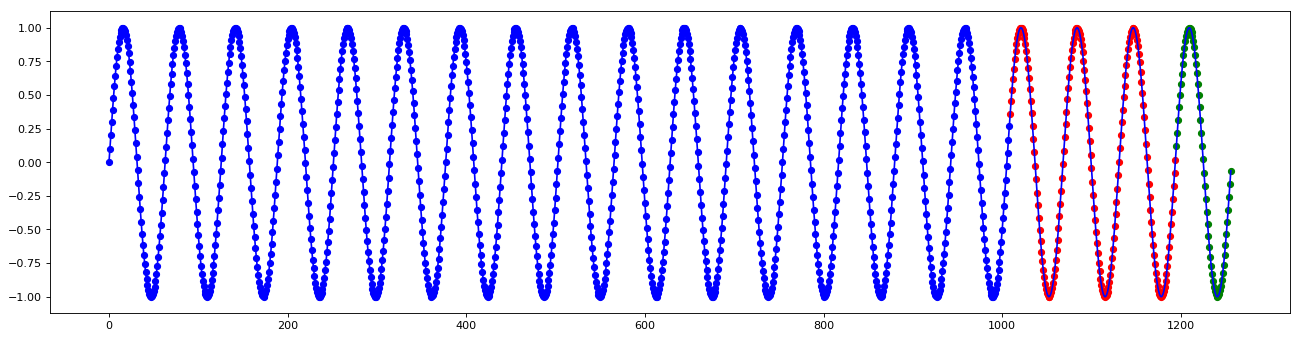

In [6]:
#Set the figure parameters
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Grab the points for each section of the plot
train_points, test_input_points, test_label_points = data[:-n_test], data[-n_test:-n_forecast], data[-n_forecast:]

#Plot the training data and the underlying curve in blue 
plt.plot(data, color="blue")
train_plot_x = [x for x in range(len(train_points))]
plt.scatter(train_plot_x, train_points, color="blue", s=30)

#Plot the test example X in red
test_input_xs = [x +len(train_points) for x in range(len(test_input_points))]
plt.scatter(test_input_xs, test_input_points, color="red", s=30)





#Plot the test target label in green
test_label_xs = [x +(len(train_points)+len(test_input_points)) for x in range(len(test_label_points))]
plt.scatter(test_label_xs, test_label_points, color="green", s=30)











# #Plot the original data using the defined train and test sizes

# #Line plot along the true data
# plt.plot(data, color="blue")

# #Plot the training points in green
# train_plot_x = [x for x in range(len(train_plot))]
# plt.scatter(train_plot_x, train_plot, color="blue", s=30)

# #Note: we have to shift the test data to plot it
# test_plot_x = [x +len(train_plot) for x in range(len(test_plot))]
# plt.scatter(test_plot_x, test_plot, color="red", s=30)


## Define LSTM architecture

* NOTE: We have to switch the input such that 2nd dimension (time_steps) is representative of how many steps to look into the past.  
* NOTE: "features" is dim 1. It is just representative of the number of dimensions in our input, nothing to do with number of points, nor the number of points on the output.

In [7]:
# fit an LSTM network to training data

def fit_lstm(train, n_prev, n_forecast, n_batch, nb_epoch, n_neurons):
    """
    Function to convert data so it can be interpreted by the LSTM and then trains and returns the LSTM model
    Note: 
    
    Input to every LSTM layer must be 3 dimensional
    - Samples: one sequence is one sample. A batch is comprised of 1 or more samples.
    - Time Steps: One time step is one point of observation in the sample.
    - Features: One feature is one observation at a time step.
    
    """
    
    architecture = ""
    # reshape training into [samples, timesteps, features]
    
    #Split the training data into X (input) and y (labels)
    X, y = train[:, 0:n_prev], train[:, n_prev:]

    print("X shape: " + str(X.shape))
    print("y shape: " + str(y.shape))
    
    #Reshape X so Samples=num_examples, TimeSteps=1, Features = n_lag
    #X = X.reshape(X.shape[0], 1, X.shape[1]) !!!!
    X = X.reshape(X.shape[0],X.shape[1],1)
    
    #y = y.reshape(1, y.shape[0])
    
    #print(y.shape[1])
    
    model = Sequential()
    #We feed in batch sizes of dimension: (n_batch, 1, n_lag)
    print((n_batch, X.shape[1], X.shape[2]))
    print(X.shape)
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    architecture += "LSTM; "
    model.add(Dense(180))
    #Last layer is a fully connected layer to output size n_forecast
    model.add(Dense(y.shape[1]))
    architecture += "Dense output; "
    #Compile the network
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy']) #Hod wants mean squared error
    
    
    
    
    #Fit the network to the training data
    history = model.fit(X, y, validation_split=0.2, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)

    
#     for i in range(nb_epoch):
#         print(i)
#         start = timer()
#         model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
#         model.reset_states()
#         end = timer()
#         print("Epoch duration: " + str(end - start))
    return model, architecture, history

In [8]:
print(train.shape)
train = train[12:]
print(train.shape)

(762, 248)
(750, 248)


## Train the Neural Network

In [43]:
n_epochs = 100
n_batch = 150
n_neurons = 200
print(len(train))
print(train.shape)
#model, architecture = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)
model, architecture,history = fit_lstm(train, n_prev, n_forecast, n_batch, n_epochs, n_neurons)


750
(750, 248)
X shape: (750, 186)
y shape: (750, 62)
(150, 186, 1)
(750, 186, 1)
Train on 600 samples, validate on 150 samples
Epoch 1/100
600/600 [==============================] - 1s 2ms/step - loss: 0.4743 - acc: 0.0467 - val_loss: 0.4180 - val_acc: 0.0667
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.3657 - acc: 0.0633 - val_loss: 0.2487 - val_acc: 0.0600
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 0.1904 - acc: 0.0600 - val_loss: 0.1396 - val_acc: 0.0933
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0942 - acc: 0.1200 - val_loss: 0.0246 - val_acc: 0.1867
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0294 - acc: 0.1550 - val_loss: 0.0353 - val_acc: 0.1533
Epoch 6/100
600/600 [==============================] - 1s 2ms/step - loss: 0.0311 - acc: 0.1567 - val_loss: 0.0203 - val_acc: 0.1400
Epoch 7/100
600/600 [==============================] - 1s 2ms/step - loss:

In [45]:
#Save model history
import pickle
with open('../training_histories/sine_train_history_dict.pickle', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [46]:
history = 0
#Restore history from file
name = '../training_histories/sine_train_history_dict'
filename = open(name + ".pickle","rb")
history = pickle.load(filename)
filename.close() 


In [47]:
print(history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


['acc', 'loss', 'val_acc', 'val_loss']
log val: -0.743809095362 -0.7438090953621733
[0.4742763042449951, 0.3657371699810028, 0.1904018223285675, 0.09418823756277561, 0.029422119725495577]
[-0.74596521 -1.00584032 -1.65861859 -2.36245997 -3.52600852]
<type 'list'>


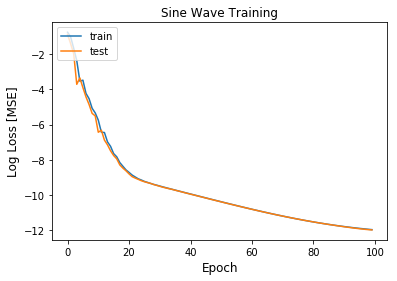

In [59]:
# list all data in history
print(history.keys())
logged = history['loss'][0:5]
print("log val: " + str(math.log(0.4753)) + " " + str(np.log(0.4753)))
print(logged)
print(np.log(logged))
print(type(logged))
# summarize history for accuracy
# plt.plot(history['acc'])
# plt.plot(history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(np.log(history['loss']))
plt.plot(np.log(history['val_loss']))
plt.title('Sine Wave Training')
plt.ylabel('Log Loss [MSE]', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
from keras.models import load_model
model.save('../checkpoints/sineLSTM_100epoch_200neuron_180dense.h5')
#model.save('loadtime_3000epoch_100batch_200neuron_180dense_div2point3.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('loadtime_200epoch_200batch_200neuron_180dense.h5')

In [43]:
from keras.utils import plot_model
plot_model(model, to_file='../assets/lstm_architecture_sine.png')

In [12]:
def forecast_lstm(model, X, n_batch):
    
    Xs = [X for _ in range(n_batch)]
    
    x_stack = np.stack((Xs))
    print(x_stack.shape)
    
    X = x_stack.reshape(n_batch,len(X),1)
    
    #Make a forecast    
    forecast = model.predict(X, batch_size=n_batch)
    
    #Convert to array
    return [y_hat for y_hat in forecast[0,:]]

In [18]:
#Run on test data
test_x, test_y = test[0:n_prev], test[n_prev:]
test_x = np.array(test_x)
y_hat = forecast_lstm(model, test_x, n_batch)
avg_RMSE = math.sqrt(mean_squared_error(test_y, y_hat))

print("Average RMSE: " + str(avg_RMSE))


(150, 186)
Average RMSE: 0.00279492375636


## Mean Absolute Error (MAE) accuracy on the Validation Data, as percentage of maximum value

In [19]:
#This should be using the "height" of the wave
max_height = max(test_y) - min(test_y)
error_sum = 0
for i in range(len(test_y)):
    error_sum += abs(test_y[i] - y_hat[i])
    
avg_error_sum = error_sum/len(test_y)
mean_abs_error_percentage = (avg_error_sum/max_height)*100
print("mean_abs_error_percentage: "+str(mean_abs_error_percentage))

mean_abs_error_percentage: 0.11121768851646537


## Display Results
* Blue: Sample used for prediction
* Green: What we are trying to predict
* Red: Actual prediction

Epochs: 100
Average RMSE: 0.00279494046777
mean_abs_error_percentage: 0.11121825366042967
Average predicted value: -0.0005095059112195045
Variance of predicted values: 0.50488234
Min: -0.99435854 Max: 0.999481


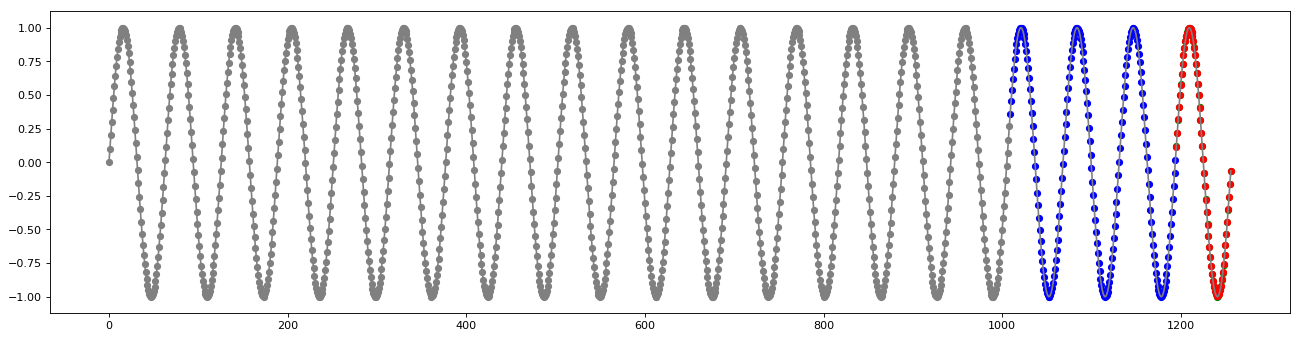

In [16]:
#Build a larger figure
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')

#Training data in Blue
plt.plot(data, color="gray")
train_plot_x = [x for x in range(len(train_points))]
plt.scatter(train_plot_x, train_points, color="gray", s=30)

#Display the input (X) for the prediction purple
test_x_start = len(data) - n_test
test_x_end = len(data) - len(y_hat)

test_x_indices = [x for x in range(test_x_start, test_x_end)]
test_x_labels = [data[y] for y in test_x_indices]

plt.scatter(test_x_indices, test_x_labels, color="blue", s=30)


#Define indices for which to plot the prediction
index_start = test_x_end
index_end = len(data)
labels_x = [x for x in range(index_start, index_end)]


#Display true labels in green
true_labels = [data[y] for y in range(index_start, index_end)]
plt.scatter(labels_x, true_labels, color="green", s=30)

#Display forecasted labels in red
plt.scatter(labels_x, y_hat, color="red", s=30)



gray_patch = mpatches.Patch(color='gray', label='Training/Validation data')

blue_patch = mpatches.Patch(color='blue', label='Test input example(X)')

green_patch = mpatches.Patch(color='green', label='True labels (Y)')

red_patch = mpatches.Patch(color='red', label='Forecast (Y-hat)')

#plt.legend(handles=[gray_patch, blue_patch, green_patch, red_patch],bbox_to_anchor=(1.04,1), loc="upper left")



# from matplotlib.font_manager import FontProperties

# fontP = FontProperties()
# fontP.set_size('large')
# plt.legend([red_patch], "dfdfd", prop=fontP)

#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")




print("Epochs: " + str(n_epochs))
print("Average RMSE: " + str(avg_RMSE))
print("mean_abs_error_percentage: "+str(mean_abs_error_percentage))
print("Average predicted value: " + str(sum(y_hat)/len(y_hat)))
print("Variance of predicted values: " + str(np.var(y_hat)))
print("Min: " + str(min(y_hat)) + " Max: "+str(max(y_hat)))